In [4]:
!pip install numpy
!pip install pycocotools
!pip install ultralytics
!pip install torchvision
!pip install pycocotools
!pip install opencv-python
!pip install matplotlib
!pip install pycocotools
!pip install scikit-image
!pip install torch

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [5]:
cd /home/cloud/old-volume/home/cloud

/home/cloud/old-volume/home/cloud


/home/cloud/.local/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [11]:
########################## Define the U-NET architecture #############################
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision import utils
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from skimage.measure import regionprops, label


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Contracting path (encoder)
        self.enc1 = self.conv_block(1, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)
        self.enc4 = self.conv_block(128, 256)
        self.enc5 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Expanding path (decoder)
        self.dec5 = self.conv_block(1024 + 512, 512)
        self.dec4 = self.conv_block(512 + 256, 256)
        self.dec3 = self.conv_block(256 + 128, 128)
        self.dec2 = self.conv_block(128 + 64, 64)
        self.dec1 = self.conv_block(64 +32, 32)

        # Final layer
        self.final = nn.Conv2d(32, 2, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Dropout2d(0.1),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True))  
     
    def forward(self, x):
        # Encoder (Downsampling with Max Pooling)
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e4 = self.enc4(F.max_pool2d(e3, 2))
        e5 = self.enc5(F.max_pool2d(e4, 2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e5, 2))

        # Decoder (Upsampling with Transpose Convolutions)
        d5 = self.dec5(torch.cat([F.interpolate(b, scale_factor=2, mode='bilinear', align_corners=True), e5], dim=1))
        d4 = self.dec4(torch.cat([F.interpolate(d5, scale_factor=2, mode='bilinear', align_corners=True),e4], dim=1))
        d3 = self.dec3(torch.cat([F.interpolate(d4, scale_factor=2, mode='bilinear', align_corners=True), e3], dim=1))
        d2 = self.dec2(torch.cat([F.interpolate(d3, scale_factor=2, mode='bilinear', align_corners=True), e2], dim=1))
        d1 = self.dec1(torch.cat([F.interpolate(d2, scale_factor=2, mode='bilinear', align_corners=True), e1], dim=1))
        
        # Final output
        #out = torch.sigmoid(self.final(d1))  # Sigmoid activation for binary segmentation
        out = self.final(d1) # output model LOGITS!
        return out

In [12]:
########### Reading input Images and masks processing block #######################

import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
from pycocotools.coco import COCO
from PIL import Image
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

class CocoBacteriaDataset(Dataset):
    def __init__(self, annotation_file, image_dir, transform=True):
        self.coco = COCO(annotation_file)  # Load COCO dataset annotations
        self.image_dir = image_dir  # Directory containing images
        self.transform = transform  # Transformations to apply
        self.image_ids = self.coco.getImgIds()  # List of image IDs in the dataset 
        # Get category IDs for OM and IM.
        self.cat_ids = self.coco.getCatIds(catNms=['OM', 'IM'])

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_metadata = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, img_metadata['file_name'])
        image = Image.open(img_path).convert("L")  # Load as grayscale

        # Convert image to tensor
        image = transforms.ToTensor()(image)  # Convert the image to tensor.ToTensor() is not simple conversion to tensor. It does PIL to Tensor + channel reordering + 0–255→0–1 scaling

        # Load multilabel segmentation masks
        h, w = img_metadata['height'], img_metadata['width']
        # Create a mask with 2 channels: [2, H, W]
        multi_mask = np.zeros((2, h, w), dtype=np.uint8)
        
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)
        for ann in annotations:
            cat_id = ann['category_id']
            channel = 0 if cat_id == self.cat_ids[0] else 1
            segmentation = ann['segmentation']
            for poly in segmentation:
                poly = np.array(poly).reshape((int(len(poly) / 2), 2)).astype(np.int32)
                cv2.fillPoly(multi_mask[channel], [poly], color=1)
        
        # Convert to tensor [2, H, W]
        mask = torch.tensor(multi_mask, dtype=torch.float32)
        raw_image, raw_mask = image.clone(), mask.clone()

        if self.transform:
            # Note: 320x320 resize should be consistent
            #image = TF.resize(image, (320, 320))
            #mask = TF.resize(mask, (320, 320))

            angle, translations, scale, shear = transforms.RandomAffine.get_params(
                degrees=(-180, 180), 
                translate=(0.1, 0.1), 
                scale_ranges=(0.9, 1.1), 
                shears=(-5, 5), 
                img_size=(320, 320))
            
            image = TF.affine(image, angle=angle, translate=translations, scale=scale, shear=shear)
            mask = TF.affine(mask, angle=angle, translate=translations, scale=scale, shear=shear)
            
        return raw_image, raw_mask, image, mask

In [13]:
#Data Loader-Load the train, Test and validation datasets

train_annotation_file = "/home/cloud/old-volume/home/cloud/bacteria-thickness_additional.v4i.coco/train/_annotations.coco.json"
train_image_dir = "/home/cloud/old-volume/home/cloud/bacteria-thickness_additional.v4i.coco/train"
train_dataset = CocoBacteriaDataset(train_annotation_file, train_image_dir, transform=True)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


valid_annotation_file = "/home/cloud/old-volume/home/cloud/bacteria-thickness_additional.v4i.coco/valid/_annotations.coco.json"
valid_image_dir = "/home/cloud/old-volume/home/cloud/bacteria-thickness_additional.v4i.coco/valid"
valid_dataset = CocoBacteriaDataset(valid_annotation_file, valid_image_dir, transform=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True)


test_annotation_file = "/home/cloud/old-volume/home/cloud/bacteria-thickness_additional.v4i.coco/test/_annotations.coco.json"
test_image_dir = "/home/cloud/old-volume/home/cloud/bacteria-thickness_additional.v4i.coco/test/"
test_dataset = CocoBacteriaDataset(test_annotation_file, test_image_dir, transform=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [15]:
import numpy as np

# Define IOU 
def calculate_iou(pred_mask, true_mask):
    ious = []
    # Loop through each channel (0=OM, 1=IM)
    for c in range(pred_mask.shape[0]):
        p = pred_mask[c]
        t = true_mask[c]
        
        # --- Your original logic applied to one channel ---
        intersection = np.logical_and(t, p).sum()
        union = np.logical_or(t, p).sum()
        iou = intersection / (union + 1e-6)        
        ious.append(iou)
    return np.mean(ious)  # Return the average across both membranes

# Define DICE
def calculate_dice(pred_mask, true_mask):
    dices = []
    # Loop through each channel (0=OM, 1=IM)
    for c in range(pred_mask.shape[0]):
        p = pred_mask[c]
        t = true_mask[c]
        
        # --- Your original logic applied to one channel ---
        intersection = np.logical_and(t, p).sum()
        dice = (2 * intersection) / (p.sum() + t.sum() + 1e-6)        
        dices.append(dice)
        
    return np.mean(dices) 

#Define Precision_Recall_F1 

def calculate_precision_recall_f1(pred_mask, true_mask):
    """
    Args:
        pred_mask (np.array): shape [2, H, W] (0 or 1)
        true_mask (np.array): shape [2, H, W] (0 or 1)
    """
    precisions, recalls, f1s = [], [], []
    
    for c in range(pred_mask.shape[0]):
        p = pred_mask[c].flatten()
        t = true_mask[c].flatten()
        
        # True Positive: Both are 1
        tp = np.sum((p == 1) & (t == 1))
        # False Positive: Predicted 1, but actually 0
        fp = np.sum((p == 1) & (t == 0))
        # False Negative: Predicted 0, but actually 1
        fn = np.sum((p == 0) & (t == 1))
        
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        
    return np.mean(precisions), np.mean(recalls), np.mean(f1s)

Raw shapes → Image: (640, 640), Mask: (640, 640)
Trans shapes → Image: (640, 640), Mask: (640, 640)


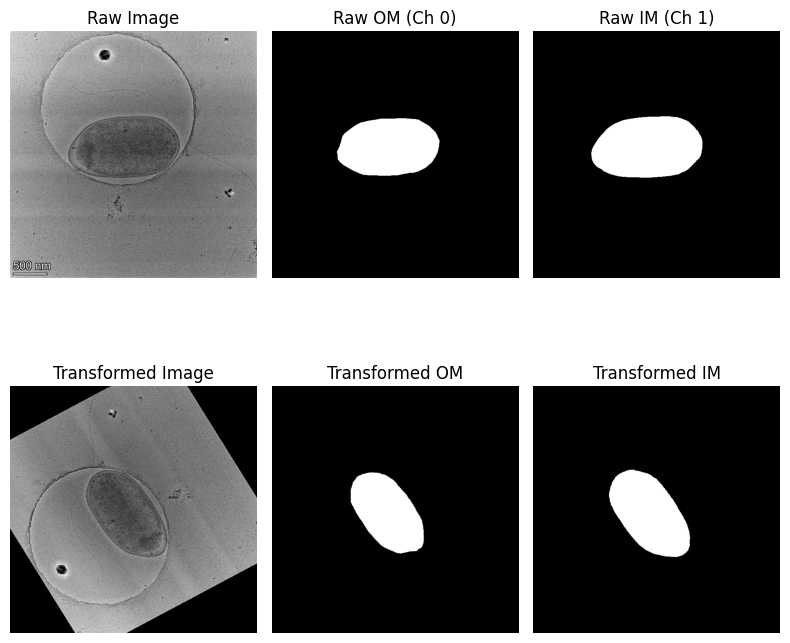

In [16]:
#################### Check if transformations are applied correctly or not. Visualize masks also ######################

import matplotlib.pyplot as plt

if len(train_loader) > 0:
    for raw_img, raw_mask, img, mask in train_loader:
        # 3 Columns: Image, Outer Membrane (Ch 0), Inner Membrane (Ch 1)
        fig, axs = plt.subplots(2, 3, figsize=(8, 8))
        
        ## 1. Convert to NumPy and Detach (Your Logic)
        # Select first image in batch [0], then specific channels
        raw_img_np  = raw_img[0, 0, :, :].detach().cpu().numpy()
        raw_om_np   = raw_mask[0, 0, :, :].detach().cpu().numpy() # Channel 0
        raw_im_np   = raw_mask[0, 1, :, :].detach().cpu().numpy() # Channel 1
        
        img_np      = img[0, 0, :, :].detach().cpu().numpy()
        trans_om_np = mask[0, 0, :, :].detach().cpu().numpy() # Channel 0
        trans_im_np = mask[0, 1, :, :].detach().cpu().numpy() # Channel 1
        
        print(f"Raw shapes → Image: {raw_img_np.shape}, Mask: {raw_om_np.shape}")
        print(f"Trans shapes → Image: {img_np.shape}, Mask: {trans_om_np.shape}")

        ## 2. Top row: originals (Your Logic)
        axs[0,0].imshow(raw_img_np, cmap='gray')
        axs[0,0].set_title("Raw Image")
        
        axs[0,1].imshow(raw_om_np, cmap='gray')
        axs[0,1].set_title("Raw OM (Ch 0)")
        
        axs[0,2].imshow(raw_im_np, cmap='gray')
        axs[0,2].set_title("Raw IM (Ch 1)")

        ## 3. Bottom row: after resize + affine (Your Logic)
        axs[1,0].imshow(img_np, cmap='gray')
        axs[1,0].set_title("Transformed Image")
        
        axs[1,1].imshow(trans_om_np, cmap='gray')
        axs[1,1].set_title("Transformed OM")
        
        axs[1,2].imshow(trans_im_np, cmap='gray')
        axs[1,2].set_title("Transformed IM")
        
        for ax in axs.flatten():
            ax.axis('off')
            
        plt.tight_layout()
        plt.show()
        break  # just the first batch
else:
    print("No data in train_loader.") 

In [18]:
########### Define Early stopping code ##############################
import torch
import torch.nn as nn
import torch.optim as optim

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, verbose=False, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss  # we want to minimize validation loss

        if self.best_score is None:
            self.best_score = score
            self._save_checkpoint(val_loss, model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"[EarlyStopping] No improvement: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if self.verbose:
                print(f"[EarlyStopping] Improvement: {self.best_score:.4f} → {score:.4f}. Saving model.")
            self.best_score = score
            self._save_checkpoint(val_loss, model)
            self.counter = 0

    def _save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)

New best‐Dice model at epoch 0: Dice=0.9130
Epoch 1/180, Training Loss: 1.1233, Validation Loss: 1.0125, IoU: 0.8412, Dice: 0.9130
[EarlyStopping] Improvement: -1.0125 → -0.9645. Saving model.
New best‐Dice model at epoch 1: Dice=0.9494
Epoch 2/180, Training Loss: 1.0017, Validation Loss: 0.9645, IoU: 0.9044, Dice: 0.9494
[EarlyStopping] Improvement: -0.9645 → -0.9004. Saving model.
Epoch 3/180, Training Loss: 0.9296, Validation Loss: 0.9004, IoU: 0.8929, Dice: 0.9429
[EarlyStopping] Improvement: -0.9004 → -0.8174. Saving model.
New best‐Dice model at epoch 3: Dice=0.9669
Epoch 4/180, Training Loss: 0.8636, Validation Loss: 0.8174, IoU: 0.9365, Dice: 0.9669
[EarlyStopping] Improvement: -0.8174 → -0.7874. Saving model.
Epoch 5/180, Training Loss: 0.8047, Validation Loss: 0.7874, IoU: 0.8909, Dice: 0.9419
[EarlyStopping] Improvement: -0.7874 → -0.6942. Saving model.
New best‐Dice model at epoch 5: Dice=0.9717
Epoch 6/180, Training Loss: 0.7470, Validation Loss: 0.6942, IoU: 0.9453, Dice:

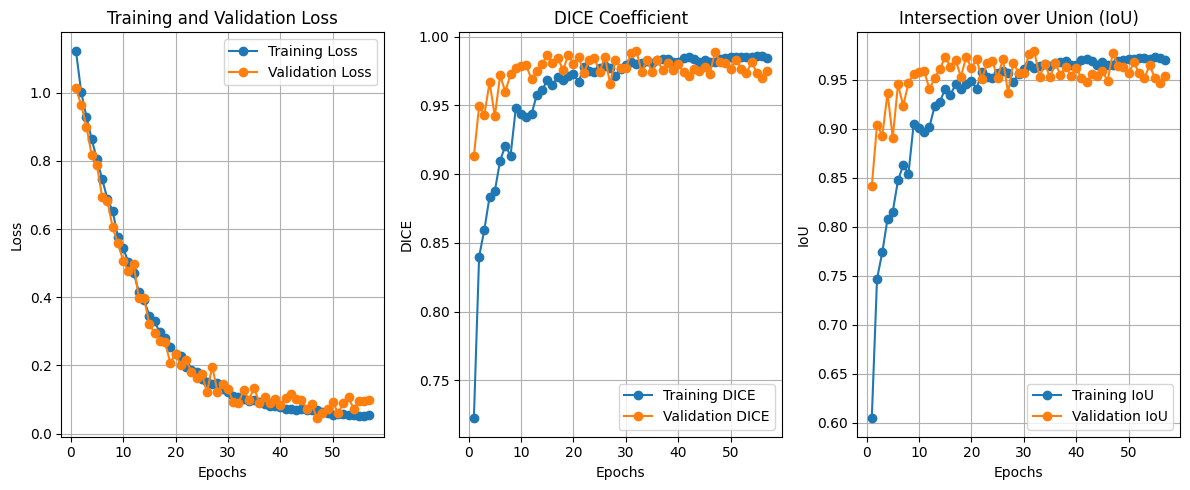

In [17]:
####### Now train the model ###########

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Lists to store results
train_losses = []
val_losses = []
train_ious = []
val_ious = []
train_dices = []
val_dices = []

# First define the DICE+BCE loss function ######
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):
        # Apply Sigmoid since the U-Net outputs raw logits
        inputs = torch.sigmoid(inputs)       
        
        # Flatten the tensors - view(-1) works for multilabel as it pools all pixel errors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # 3. Calculate Dice Loss
        intersection = (inputs * targets).sum()                            
        dice_score = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        dice_loss = 1 - dice_score
        
        # 4. Calculate Binary Cross Entropy Loss
        bce_loss = F.binary_cross_entropy(inputs, targets, reduction='mean')
        
        # 5. Combine them 
        return bce_loss + dice_loss
        
# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)  # Ensure your UNet final layer is nn.Conv2d(..., 2, ...)

# Loss and optimizer
criterion = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# 2. Early stopping callback
early_stopper = EarlyStopping(patience=10, min_delta=1e-3, verbose=True, 
                              path='best_multi_unet.pt')

# Best‐Dice tracker
best_val_dice = 0.0

num_epochs = 180
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0
    total_iou = 0
    total_dice = 0
  
    # Training
    for raw_imgs, raw_masks, images, masks in train_loader:
        images, masks = images.to(device), masks.to(device) 

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate IoU and Dice for training set
        probs = torch.sigmoid(outputs)
        # Convert to NumPy [Batch, 2, H, W]
        pred_mask = (probs > 0.5).cpu().numpy().astype(np.uint8)
        true_mask = masks.cpu().numpy().astype(np.uint8)
        
        # Loop over batch size
        for i in range(pred_mask.shape[0]):  
            # Removed the ", 0" so it passes the [2, H, W] stack to your multilabel functions
            total_iou += calculate_iou(pred_mask[i], true_mask[i])
            total_dice += calculate_dice(pred_mask[i], true_mask[i])
        total_train_loss += loss.item()
        
    # Average metrics over the entire training set
    avg_train_loss = total_train_loss / len(train_loader)
    avg_iou = total_iou / len(train_loader.dataset)
    avg_dice = total_dice / len(train_loader.dataset)

    # Append results to lists
    train_losses.append(avg_train_loss)
    train_ious.append(avg_iou)
    train_dices.append(avg_dice)

    # Validation
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0 
    total_val_iou = 0
    total_val_dice = 0

    with torch.no_grad():
        for raw_vimgs, raw_vmasks, val_images, val_masks in valid_loader:
            val_images, val_masks = val_images.to(device), val_masks.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_masks)
            total_val_loss += val_loss.item()

            # Apply sigmoid to get probabilities
            val_probs = torch.sigmoid(val_outputs)
            
            # Threshold to get prediction
            val_pred_mask = (val_probs > 0.5).cpu().numpy().astype(np.uint8)
            val_true_mask = val_masks.cpu().numpy().astype(np.uint8)

            for i in range(val_pred_mask.shape[0]):  # Loop over batch size
                # Removed the ", 0" to process both channels
                total_val_iou += calculate_iou(val_pred_mask[i], val_true_mask[i])
                total_val_dice += calculate_dice(val_pred_mask[i], val_true_mask[i])

    # Average metrics over the validation set
    avg_val_loss = total_val_loss / len(valid_loader)
    avg_val_iou = total_val_iou / len(valid_loader.dataset)
    avg_val_dice = total_val_dice / len(valid_loader.dataset)

    # Append validation results to lists
    val_losses.append(avg_val_loss)
    val_ious.append(avg_val_iou)
    val_dices.append(avg_val_dice)

    early_stopper(avg_val_loss, model)
    # Break if flagged
    if early_stopper.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break
        
    # ——— Best‐Dice Checkpoint ———
    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        torch.save(model.state_dict(), 'best_unet_dice.pt')
        print(f"New best‐Dice model at epoch {epoch}: Dice={best_val_dice:.4f}")
        
    # Print metrics
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, "
          f"IoU: {avg_val_iou:.4f}, "
          f"Dice: {avg_val_dice:.4f}")

# Use the length of the actual data collected
actual_epochs = range(1, len(train_losses) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(actual_epochs, train_losses, label='Training Loss', marker='o')
plt.plot(actual_epochs, val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot DICE
plt.subplot(1, 3, 2)
plt.plot(actual_epochs, train_dices, label='Training DICE', marker='o')
plt.plot(actual_epochs, val_dices, label='Validation DICE', marker='o')

plt.title('DICE Coefficient')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.legend()
plt.grid()

# Plot IoU
plt.subplot(1, 3, 3)
plt.plot(actual_epochs, train_ious, label='Training IoU', marker='o')
plt.plot(actual_epochs, val_ious, label='Validation IoU', marker='o')
plt.title('Intersection over Union (IoU)')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [20]:
! pip install pandas

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 12.8 MB 2.9 MB/s            


Starting inference on 15 images...

--- Final Test Results ---
Average IoU: 0.9815
Average Dice: 0.9906
Precision: 0.9895
Recall: 0.9919
F1-Score: 0.9906


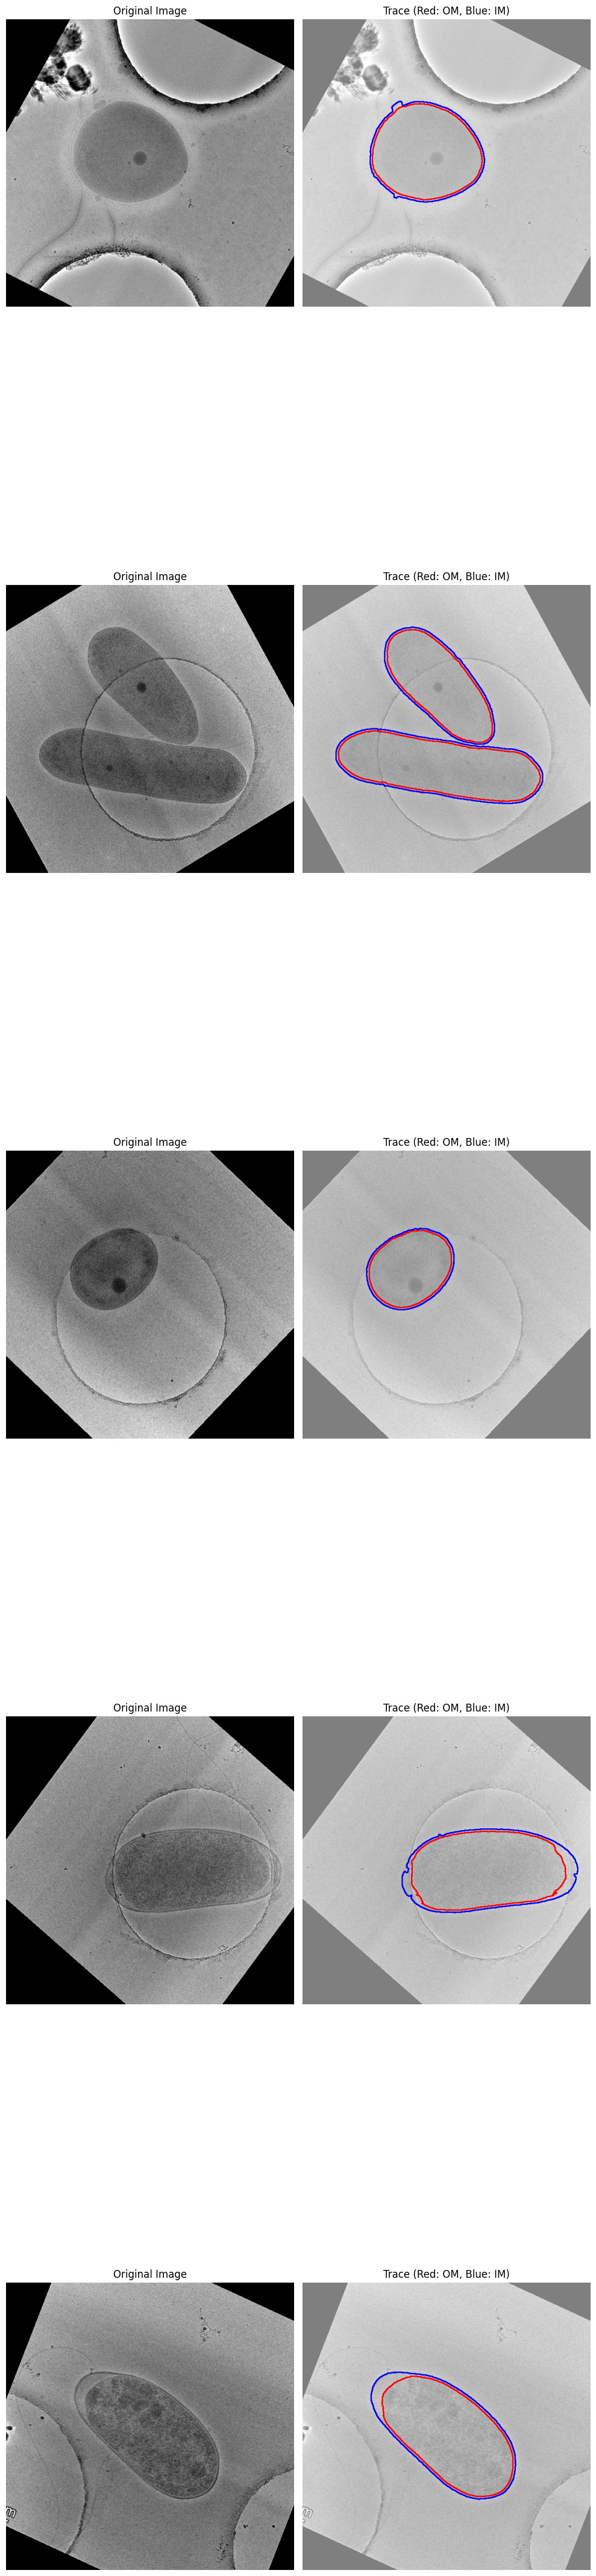

In [18]:
################# Inference on test set loader images #######################

import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

model_path = "/home/cloud/old-volume/home/cloud/best_unet_dice.pt"
model.load_state_dict(torch.load(model_path, map_location=device))

total_test_iou = 0
total_test_dice = 0
total_precision = 0
total_recall = 0
total_f1 = 0
test_results = [] 

print(f"Starting inference on {len(test_loader.dataset)} images...")

with torch.no_grad():
    for i, (raw_imgs, raw_masks, images, masks) in enumerate(test_loader):
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        
        # Threshold to get binary predictions [Batch, 2, H, W]
        pred_masks = (probs > 0.5).cpu().numpy().astype(np.uint8)
        true_masks = masks.cpu().numpy().astype(np.uint8)

        # Calculate metrics for each image in the batch
        batch_size = images.size(0)
        for j in range(batch_size):
            p = pred_masks[j] 
            t = true_masks[j]

            pr, re, f1 = calculate_precision_recall_f1(p, t)
            total_precision += pr
            total_recall += re
            total_f1 += f1
            
            # Use your multilabel metric functions
            total_test_iou += calculate_iou(p, t)
            total_test_dice += calculate_dice(p, t)

            # Store the first few samples for the visualization block below
            if len(test_results) < 5:
                # Store (Image Tensor, Ground Truth Mask, Predicted Mask)
                test_results.append((images[j, 0].cpu(), t, p))

# Final Metrics Calculation
avg_precision = total_precision / len(test_loader.dataset)
avg_recall = total_recall / len(test_loader.dataset)
avg_f1 = total_f1 / len(test_loader.dataset)
avg_test_iou = total_test_iou / len(test_loader.dataset)
avg_test_dice = total_test_dice / len(test_loader.dataset)

print(f"\n--- Final Test Results ---")
print(f"Average IoU: {avg_test_iou:.4f}")
print(f"Average Dice: {avg_test_dice:.4f}")
print(f"Precision: {avg_precision:.4f}")
print(f"Recall: {avg_recall:.4f}")
print(f"F1-Score: {avg_f1:.4f}")

# 3. Visualize with Overlays (Visualization Block)
fig, axs = plt.subplots(len(test_results), 2, figsize=(10, 10 * len(test_results)))

for idx, (img_tensor, target, pred) in enumerate(test_results):
    # Convert normalized tensor (mean=0.5, std=0.5) back to 0-255
    img_np = (img_tensor.numpy() * 0.5 + 0.5) * 255
    img_np = np.clip(img_np, 0, 255).astype(np.uint8)
    
    # Create RGB version for color tracing
    overlay_img = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
    
    # --- Process Outer Membrane (Channel 0) - RED ---
    om_mask = pred[0]
    om_contours, _ = cv2.findContours(om_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    clean_om = [cnt for cnt in om_contours if cv2.contourArea(cnt) > 500]
    cv2.drawContours(overlay_img, clean_om, -1, (255, 0, 0), 2)
    
    # --- Process Inner Membrane (Channel 1) - BLUE ---
    im_mask = pred[1]
    im_contours, _ = cv2.findContours(im_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    clean_im = [cnt for cnt in im_contours if cv2.contourArea(cnt) > 200]
    cv2.drawContours(overlay_img, clean_im, -1, (0, 0, 255), 2)
    
    # --- Plotting ---
    axs[idx, 0].imshow(img_np, cmap='gray')
    axs[idx, 0].set_title("Original Image")
    axs[idx, 0].axis('off')
    
    axs[idx, 1].imshow(overlay_img)
    axs[idx, 1].set_title("Trace (Red: OM, Blue: IM)")
    axs[idx, 1].axis('off')

plt.tight_layout()
plt.show()

In [21]:
import os
import torch
import numpy as np
import cv2
import pandas as pd
from skimage.measure import regionprops, label

# ==========================================
# 1. Setup & Calibration
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nm_per_pix = 0.898  # Your calibration factor
model.eval()

records = []

# ==========================================
# 2. Iterate through Test Loader
# ==========================================
with torch.no_grad():
    for raw_imgs, raw_masks, images, masks in test_loader:
        images = images.to(device)
        
        # Get U-Net Predictions
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        pred_masks = (probs > 0.5).cpu().numpy().astype(np.uint8) # [B, 2, H, W]

        batch_size = images.size(0)
        for j in range(batch_size):
            # Extract OM (0) and IM (1)
            om_mask = pred_masks[j, 0]
            im_mask = pred_masks[j, 1]
            
            # --- Extract Metrics for OM ---
            om_label = label(om_mask)
            om_props = regionprops(om_label)
            
            if om_props:
                om_region = max(om_props, key=lambda r: r.area)
                
                # Area and Perimeter calculations
                area_nm2 = om_region.area * (nm_per_pix**2)
                perim_nm = om_region.perimeter * nm_per_pix
                
                # Periplasmic Area Logic (OM Area - IM Area)
                im_label = label(im_mask)
                im_props = regionprops(im_label)
                periplasm_area_nm2 = 0
                if im_props:
                    im_region = max(im_props, key=lambda r: r.area)
                    periplasm_area_nm2 = area_nm2 - (im_region.area * (nm_per_pix**2))

                records.append({
                    "Image_Index": j,
                    "OM_Area_nm2": area_nm2,
                    "OM_Perimeter_nm": perim_nm,
                    "OM_Eccentricity": om_region.eccentricity,
                    "Periplasm_Area_Estimate_nm2": periplasm_area_nm2,
                    "OM_Orientation_deg": np.degrees(om_region.orientation)
                })

# ==========================================
# 3. Save as CSV for GitHub Repo
# ==========================================
df = pd.DataFrame(records)
df.to_csv("quantitative_morphometry_results.csv", index=False)
print("Morphometry Tool: Analysis Complete. CSV generated.")
display(df)

Morphometry Tool: Analysis Complete. CSV generated.


,Image_Index,OM_Area_nm2,OM_Perimeter_nm,OM_Eccentricity,Periplasm_Area_Estimate_nm2,OM_Orientation_deg
0,0,32555.335884,718.041804,0.510606,-3233.680040,-53.652582
1,1,31260.251060,924.483419,0.975013,-29243.434656,-40.325291
2,2,15278.936588,466.409408,0.616754,-2098.263208,-24.948434
3,3,39371.062492,852.954220,0.898636,-6188.344296,-76.675013
4,0,35510.806544,767.586816,0.847115,-5245.658020,-44.254666
5,1,35639.831184,900.086003,0.950659,-4016.698324,-8.334732
6,2,38853.351124,866.472554,0.919794,-3710.264804,-19.599259
7,3,19749.640364,539.158357,0.658784,-2645.005120,-32.263872
8,0,29130.538096,667.689046,0.791159,-6110.929512,-89.826860
9,1,40016.992096,1031.387338,0.966067,-17298.172204,-61.610330
